## [E-16] 프로젝트 - Movielens 영화 SBR
이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

### Data Preprocess
#### Data Load
데이터를 불러와 살펴보고 주요 통계치들을 살펴봅시다.

In [1]:
import datetime as dt
from pathlib import Path
import os 

import numpy as np

import pandas as pd
import tensorflow

import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


1) 데이터 확인
$ ls -l ~/data

2) 프로젝트 폴더 생성
$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
$ ln -s ~/data/* ~/aiffel/yoochoose/data

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::',
                       header=None, usecols=[0, 1, 2, 3],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32},
                       nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

### Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, User length, User time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 User이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 User 단위로 어떻게 해석할지에 주의합니다.

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### Session Lengt
각 세션이 대략 몇 개의 클릭 데이터를 갖는지 확인

In [4]:
User_length = data.groupby('UserId').size()
User_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- 여기서 UserId_length란 같은 UserId를 공유하는 데이터 row의 개수를 의미.
- 여기서 UserId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 UserId 기준으로 모아서 분류해낼 수는 있음.
- 따라서 여기서 UserId_length란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미가 됨.

In [5]:
User_length.median(), User_length.mean()

(96.0, 165.5975165562914)

한 user당 평균적으로 165편의 영화를 봤다고 볼 수 있음.

In [6]:
User_length.min(), User_length.max()

(20, 2314)

In [7]:
User_length.quantile(0.99)

906.659999999998

99% 유저의 길이는 906 이하.

In [8]:
long_session = User_length[User_length==2314].index[0]
data[data['UserId']==long_session].head(10)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


In [9]:
length_count = User_length.groupby(User_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

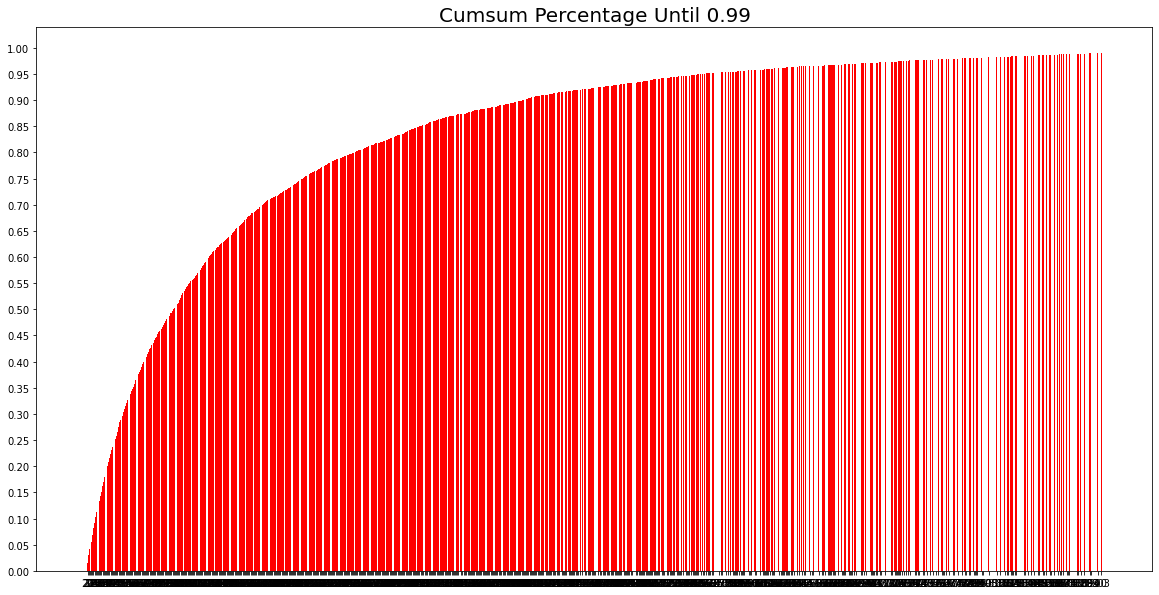

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

위의 그래프는 시청한 영화를 user 별로 누적하여 보여줌.

#### Session Time

In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


2000년~2003년까지 총 3년치 데이터가 있음.

In [12]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

#### Data Cleansing

In [14]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_User(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_User(data: pd.DataFrame, shortest):
    User_len = data.groupby('UserId').size()
    User_use = User_len[User_len >= shortest].index
    data = data[data['UserId'].isin(User_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=4, least_click=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [16]:
# test_path = data_path / 'yoochoose-test.dat'
# test= load_data(test_path)
# test['Time'].min(), test['Time'].max()

In [17]:
data = data.sort_values(by=['Time'])

#### Train / Valid / Test split

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    User_last_time = data.groupby('UserId')['Time'].max()
    User_in_train = User_last_time[User_last_time < final_time - dt.timedelta(n_days)].index
    User_in_test = User_last_time[User_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(User_in_train)]
    after_date = data[data['UserId'].isin(User_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [19]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 811062
	 Users: 5549
	 Items: 3582
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-04 22:46:11

* valid Set Stats Info
	 Events: 49590
	 Users: 152
	 Items: 3241
	 First Time : 2000-05-01 20:45:43
	 Last Time : 2002-09-01 00:14:13

* test Set Stats Info
	 Events: 139428
	 Users: 339
	 Items: 3379
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



- Events: 데이터 갯수
- Sessions: UserId의 고유값
- Items: ItemId의 고유값
- First Time : 최소시간
- Last Time : 최대시간

3년치 데이터 중에서 3개월은 valid 데이터, 마지막 3개월은 test 데이터로 사용.

In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### Data Pipeline
이전 스텝에서 개념을 정리해 본 Session-Parallel Mini-Batch를 구현해 봅니다.

#### SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999877,6040,1419,3,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999920,6040,213,5,2000-04-25 23:07:36,9


In [26]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 810598, 810721, 811062], dtype=int32)

In [27]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5546, 5547, 5548])

#### SessionDataLoader
파이썬 문법 중 iterator, generator에 대한 좀 더 친절한 안내가 필요하신 분은 이 자료를 먼저 보시길 권장합니다.

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다. iter 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다. mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head

<bound method NDFrame.head of          UserId  ItemId  Rating                Time  item_idx
1000138    6040     858       4 2000-04-25 23:05:32         0
999873     6040     593       5 2000-04-25 23:05:54         1
1000153    6040    2384       4 2000-04-25 23:05:54         2
1000007    6040    1961       4 2000-04-25 23:06:17         3
1000192    6040    2019       5 2000-04-25 23:06:17         4
...         ...     ...     ...                 ...       ...
618253     3746    3623       3 2002-03-04 22:02:43      2741
618186     3746    3208       1 2002-03-04 22:02:43       696
618198     3746    1476       4 2002-03-04 22:04:16      1355
618409     3746    2916       4 2002-03-04 22:07:50       422
335121     1978     593       4 2002-03-04 22:46:11         1

[811062 rows x 5 columns]>

In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
# 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.
# input, output, mask의 감을 잡아 봅시다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 106 210]
Label Item Idx are :       [  1  54 177 211]
Previous Masked Input Idx are []


### Step 3. 모델 구성
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

#### Evaluation Metric
모델 성능 평가를 위한 지표를 보겠습니다. 모델 성능에 대한 지표로 precision이나 recall이 있습니다. Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다. 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다. 추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다. 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다. 이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture
스텝 3에서 소개한 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [36]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3582)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  545100    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3582)              182682    
Total params: 727,782
Trainable params: 727,782
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

#### Model Training
지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해야 하는데요.

모델 학습에 걸리는 시간은 epoch당 30분이 넘어갑니다. 그러므로 모델 학습 직전까지만 작성해 봅시다.

배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 참고해 주세요.

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

### Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

#### 모델 성능 평가를 위한 지표
* Rank-less recommendation metrics
1. Recall@k: 전체 relevant한 아이템 중 추천된 아이템이 속한 비율. 분모는 전체 relevant한 아이템의 갯수, 분자는 k개의 추천 중 relevant한 아이템의 갯수. 여기서 recall의 의미는 useful stuff에 대한 추천을 최대한 놓치지 않는 것.

2. Precision@k: k개의 추천 중 실제로 사용자가 선호하는 아이템이 얼마나 존재하는지 측정하는 지표. 분모는 추천한 아이템의 갯수, 분자는 relevant한 아이템의 갯수. 여기서 Precision의 의미는 사용자에게 useful한 item을 얼마나 잘 추천해주었는가.
3. Hit@k: 때로는 hit@k를 사용. k개의 추천 중에 relevant한 것이 있으면 1 아니면 0.

* Rank-aware recommendation metricsPermalink
1. MRR: MRR은 Mean Reciprocal Rank의 약자. Reciprocal rank는 첫 번째로 등장하는 relevant한 아이템이 우리의 추천상 몇 번째에 위치하는지를 나타내는 지표. 하지만 그대로 몇 번째인지를 사용하면 앞에 나올 수록 좋은 모델이라는 것을 반대로 표현하게되니 역수를 취해줌.
2. MAP: MAP는 Mean Average Precision의 약자. Average Precision은 precision@k에서 k를 점점 늘려가며 얻게되는 precision score를 평균낸 것. 추천의 대상들을 ordered list라고 생각하고 첫 번째 추천부터 차례로 내려가며 relevant 아이템이 나올때마다 precision을 구해서 평균내는 것. ‘Mean’이 의미하는 것처럼 모든 사용자에 대해 Average precision을 구해 평균내면 MAP를 구할 수 있음.
3. nDCG: nDCG는 normalized Discounted Cumulative Gain의 약자. relevance score의 값과 순위를 모두 반영한 DCG라는 metric을 구할 수 있음. 0~1의 일정한 범위를 가지며 상대적인 선호도를 고려하는 metric.

[참고](https://zzaebok.github.io/recommender_system/metrics/rec_metrics/)

#### Inference
지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증해 봅시다.

In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### model
* batch_size = 128
* hsz=50
* drop_rate=0.1
* lr=0.001

In [40]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3582)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    545100    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3582)               182682    
Total params: 727,782
Trainable params: 727,782
Non-trainable params: 0
_________________________________________________________________


Evaluation:  26%|██▌       | 101/386 [00:56<02:39,  1.79it/s]


	 - Recall@20 epoch 1: 0.135133
	 - MRR@20    epoch 1: 0.029695



Evaluation:  26%|██▌       | 101/386 [00:53<02:31,  1.88it/s]


	 - Recall@20 epoch 2: 0.202042
	 - MRR@20    epoch 2: 0.046568



Evaluation:  26%|██▌       | 101/386 [00:53<02:30,  1.89it/s]


	 - Recall@20 epoch 3: 0.214418
	 - MRR@20    epoch 3: 0.051116



Evaluation:  26%|██▌       | 101/386 [00:52<02:29,  1.91it/s]


	 - Recall@20 epoch 4: 0.224474
	 - MRR@20    epoch 4: 0.053160



Evaluation:  26%|██▌       | 101/386 [00:52<02:28,  1.92it/s]

	 - Recall@20 epoch 5: 0.227027
	 - MRR@20    epoch 5: 0.054892



In [41]:
test_model(model, args, test)

Evaluation:  72%|███████▏  | 778/1086 [06:43<02:39,  1.93it/s]

	 - Recall@20: 0.234696
	 - MRR@20: 0.055880



### model2
* batch_size = 128
* hsz=100
* drop_rate=0.1
* lr=0.001

In [42]:
args2 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3582)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1105200   
_________________________________________________________________
dropout_2 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_2 (Dense)              (128, 3582)               361782    
Total params: 1,466,982
Trainable params: 1,466,982
Non-trainable params: 0
_________________________________________________________________


Evaluation:  26%|██▌       | 101/386 [00:54<02:32,  1.87it/s]


	 - Recall@20 epoch 1: 0.175820
	 - MRR@20    epoch 1: 0.040878



Evaluation:  26%|██▌       | 101/386 [00:52<02:28,  1.92it/s]


	 - Recall@20 epoch 2: 0.215114
	 - MRR@20    epoch 2: 0.050509



Evaluation:  26%|██▌       | 101/386 [00:52<02:28,  1.92it/s]


	 - Recall@20 epoch 3: 0.222153
	 - MRR@20    epoch 3: 0.054775



Evaluation:  26%|██▌       | 101/386 [00:52<02:27,  1.93it/s]


	 - Recall@20 epoch 4: 0.227027
	 - MRR@20    epoch 4: 0.057327



Evaluation:  26%|██▌       | 101/386 [00:52<02:27,  1.93it/s]

	 - Recall@20 epoch 5: 0.231745
	 - MRR@20    epoch 5: 0.058735



In [43]:
test_model(model2, args2, test)

Evaluation:  72%|███████▏  | 778/1086 [06:40<02:38,  1.94it/s]

	 - Recall@20: 0.239306
	 - MRR@20: 0.058945



### model3
* batch_size = 64
* hsz=100
* drop_rate=0.1
* lr=0.001

In [44]:
args3 = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3582)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1105200   
_________________________________________________________________
dropout_3 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (64, 3582)                361782    
Total params: 1,466,982
Trainable params: 1,466,982
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 553/772 [02:34<01:01,  3.58it/s]


	 - Recall@20 epoch 1: 0.194168
	 - MRR@20    epoch 1: 0.044457



Evaluation:  72%|███████▏  | 553/772 [02:31<01:00,  3.64it/s]


	 - Recall@20 epoch 2: 0.224486
	 - MRR@20    epoch 2: 0.053585



Evaluation:  72%|███████▏  | 553/772 [02:30<00:59,  3.67it/s]


	 - Recall@20 epoch 3: 0.234545
	 - MRR@20    epoch 3: 0.056490



Evaluation:  72%|███████▏  | 553/772 [02:30<00:59,  3.68it/s]


	 - Recall@20 epoch 4: 0.236522
	 - MRR@20    epoch 4: 0.057869



Evaluation:  72%|███████▏  | 553/772 [02:30<00:59,  3.68it/s]

	 - Recall@20 epoch 5: 0.238613
	 - MRR@20    epoch 5: 0.058367



In [45]:
test_model(model3, args3, test)

Evaluation:  87%|████████▋ | 1887/2173 [08:32<01:17,  3.68it/s]

	 - Recall@20: 0.231493
	 - MRR@20: 0.058376



# 회고

### model
(batch_size = 128, hsz=50, drop_rate=0.1, lr=0.001)
- Recall@20: 0.234164
- MRR@20: 0.055969

### model2
(batch_size = 128, hsz=100, drop_rate=0.1, lr=0.001)
- Recall@20: 0.239788
- MRR@20: 0.059341

### model3
(batch_size = 64, hsz=100, drop_rate=0.1, lr=0.001)
- Recall@20: 0.231907
- MRR@20: 0.058383
    
-----

처음에 모델 훈련시키는데 배치사이즈를 256으로 했더니 인덱스가 축방향을 벗어났다고 오류가 떴다. 뭐가 문제인지 모르겠어서 구글에 검색하다가 배치사이즈가 크면 인덱스가 축범위를 벗어났다는 에러가 뜬다고 한다. 배치사이즈를 다시 조절하여 모델을 훈련하니 정상적으로 작동..! (배치사이즈가 작아도 텐서가 안맞는다고 뜬다고 한다.) 그런데, 왜 배치사이즈를 작게 해야하는지에 대해서 찾아봤지만 정확한 이유를 모른다는게 아쉽다.

lms를 기준으로 프로젝트를 진행하다가 한번씩 에러가 나서 해결한다고 한참을 잡고 있었더니 이번 프로젝트는 좀 깊이 코드를 들여다보고 이해할 수 있어서 '드디어 코드가 좀 눈에 보이는구나!' 하고 감격했지만 에러 해결이 안되서 방법을 찾지 못해서 몇 번의 구글링과 우수노드 정독 끝에 에러를 잡아내는데 성공했다.

에러난 부분이 뭐였냐면 처음에는 time 데이터셋의 형이 틀려서 형변환을 해야하는데 이 부분을 계속 놓치고 있었는데 발견하여 수정하니 진행이 됐다. (Time 변수(int64 타입) → datetime형으로 변환)
또 한 부분은 최종 30일 이전 데이터를 확인하는 부분에서 데이터가 너무 적어서 lms와 동일하게 가기에는 무리가 있다고 생각해서 전체데이터를 다 사용했다.

n_days=180을 batch_size는 50가 100중에 고민하다가 50으로 잡았는데 100으로 했으면 결과가 또 어떻게 달랐을까 생각해본다. (혹시 배치사이즈가 크다고 에러뜬게 이거 때문인가??)
프로젝트 제출 이후 하이퍼파라미터 조절을 하며 좀더 테이트를 해보려고 한다.
(시간 관계상 일단 제출해야하는 상황..;;)

루브릭 3번의 Recall, MRR 등의 변화추이를 관찰하였다를 평가하고 싶은데 평가 기준을 어떻게 잡아야할지 모르겠어서 또 한참 다른 분들의 노드를 정독했다.
그 결과, 가장 높은 값이 나온 걸 기준으로 평가를 해야한다고 판단되어 하이퍼파라미터나 에폭 조절을 더 해서 비교해 보려고 했으나 지금 model1,2,3 돌린 것도 언제 완료 될지 모르겟어서 역시나 일단 제출..ㅠㅠ (한 시간 안에 모델 2,3이 돌아가야 할텐데..^^; 에폭 10으로 했으면 큰일날뻔.. 에폭 10도 비교해봐야 하는데..ㅠㅠ)


3가지 모델 모두 비슷비슷한 성능이여서 비교하기 참 난해하긴 하다.
* Recall 값 : model2가 비교적 가장 높은 값이다.
* MRR 값 : model2가 비교적 가장 높은 값이다.

결론적으로, model1,2,3 중에서 비교적 성능이 좋은 것은 model2라고 할 수 있다.